# SPIRE-NEP master catalogue
## Preparation of SEIP data

This catalogue comes from `dmu0_SEIP`.

In the catalogue, we keep:

the first aperture (3.8 arcsec) fluxes as this is closes to the HELP 2 arcsec standard.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "seip_ra"
DEC_COL = "seip_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "objid":     "seip_id",
        "ra":        "seip_ra",
        "dec":       "seip_dec",
        "i1_f_ap1":  "f_ap_irac_i1",
        "i1_df_ap1": "ferr_ap_irac_i1",
        "i2_f_ap1":  "f_ap_irac_i2",
        "i2_df_ap1": "ferr_ap_irac_i2",
        "i3_f_ap1":  "f_ap_irac_i3",
        "i3_df_ap1": "ferr_ap_irac_i3",
        "i4_f_ap1":  "f_ap_irac_i4",
        "i4_df_ap1": "ferr_ap_irac_i4",

    })


catalogue = Table.read("../../dmu0/dmu0_SEIP/data/SEIP_SPIRE-NEP.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2012

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        # -999 is used for missing values
        catalogue[col][catalogue[col] < -900] = np.nan
        catalogue[errcol][catalogue[errcol] < -900] = np.nan     
        
        mag, error = flux_to_mag(np.array(catalogue[col]*1.e-6), np.array(catalogue[errcol]*1.e-6))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(mag , name="m{}".format(col[1:])))
        catalogue.add_column(Column(error , name="m{}".format(errcol[1:])))
        
        # Band-flag column
        #catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/env

In [6]:
#Only keep irac i1 detected objects
catalogue = catalogue[~np.isnan(catalogue['f_ap_irac_i1'])]

In [7]:
catalogue[:10].show_in_notebook()

idx,seip_id,seip_ra,seip_dec,f_ap_irac_i1,ferr_ap_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,f_ap_irac_i3,ferr_ap_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,m_ap_irac_i1,merr_ap_irac_i1,m_ap_irac_i2,merr_ap_irac_i2,m_ap_irac_i3,merr_ap_irac_i3,m_ap_irac_i4,merr_ap_irac_i4
,,deg,deg,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,
0,SSTSL2 J174232.97+685830.3,265.637381,68.975086,23.13,0.249,29.94,0.5083,24.8,1.556,nan,nan,20.489560918073458,0.011688210764581678,20.209370509982413,0.018432856141568373,20.413870797934457,0.06812119091143747,nan,nan
1,SSTSL2 J174232.88+685852.7,265.637004,68.981326,22.05,0.2183,25.94,0.4646,nan,nan,19.28,2.607,20.541478515490347,0.010749034625791366,20.36507507062985,0.01944614652007043,nan,nan,20.687232426082964,0.1468109069400645
2,SSTSL2 J174233.91+685909.1,265.641315,68.985886,27.41,0.2666,27.68,0.5252,13.5,1.956,nan,nan,20.305227411151257,0.010560279904725182,20.2945847855382,0.020600746197217107,21.074165578762482,0.15731111233384454,nan,nan
3,SSTSL2 J174233.96+685916.6,265.641541,68.987957,26.28,0.2374,21.58,0.4456,nan,nan,nan,nan,20.35093659778064,0.009807982306300606,20.564871399132777,0.022419094200195666,nan,nan,nan,nan
4,SSTSL2 J174234.11+685922.4,265.642151,68.989574,30.61,0.2814,24.26,0.4494,nan,nan,21.34,3.011,20.18534167600665,0.009981253447204757,20.43777300867361,0.020112524749311758,nan,nan,20.577013962278862,0.1531936135204652
5,SSTSL2 J174231.02+685923.3,265.629284,68.989824,11.82,0.1972,8.38,0.3896,nan,nan,nan,nan,21.21845630863691,0.01811397458361278,21.591889953424307,0.05047766412574787,nan,nan,nan,nan
6,SSTSL2 J174232.44+685937.9,265.635199,68.993877,10.06,0.2353,11.39,0.3932,nan,nan,7.99,2.457,21.393505048200232,0.025395002880674738,21.258690689802243,0.03748125335477581,nan,nan,21.64363305171502,0.3338740744794398
7,SSTSL2 J174232.05+685932.9,265.633561,68.992499,21.14,0.2793,18.6,0.4217,nan,nan,29.63,2.663,20.58723754257148,0.014344660453592502,20.726217639455207,0.024615857932607697,nan,nan,20.220670871299866,0.09758067881440763
8,SSTSL2 J174203.53+685213.0,265.514735,68.870298,11.13,0.2249,nan,nan,nan,nan,nan,nan,21.283762089163226,0.021939090067394723,nan,nan,nan,nan,nan,nan


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:
SORT_COLS = ['merr_ap_irac_i1', 'merr_ap_irac_i2', 'merr_ap_irac_i3', 'merr_ap_irac_i4']
FLAG_NAME = 'ps1_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 10158 sources.
The cleaned catalogue has 9018 sources (1140 removed).
The cleaned catalogue has 1140 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_SPIRE-NEP.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

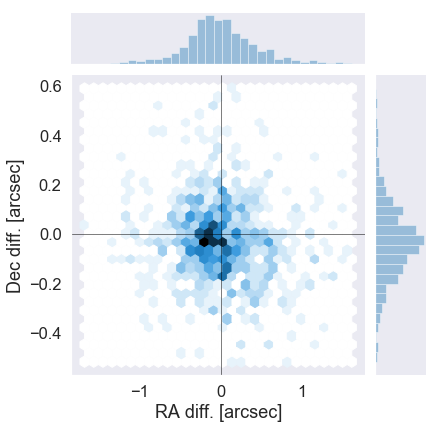

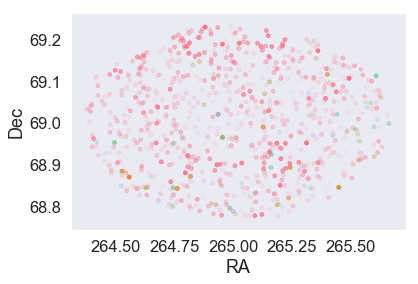

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.04006055887657567 arcsec
Dec correction: 0.0320336816400868 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

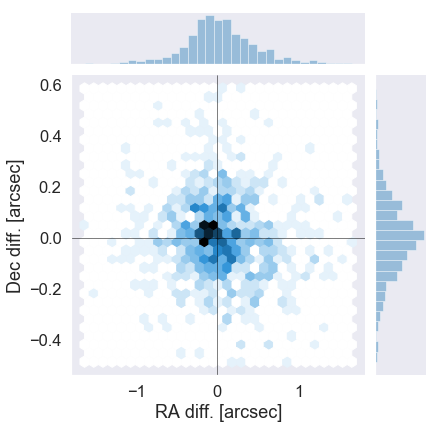

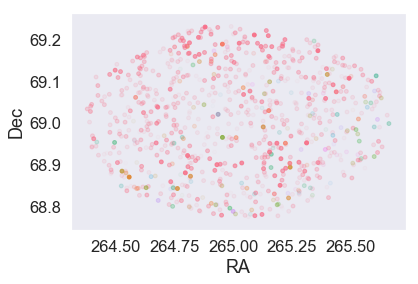

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "seip_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

831 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/SEIP.fits".format(OUT_DIR), overwrite=True)